# Using JATIC's Image Classification Protocol with `xaitk-saliency`

This is a simple notebook demonstrating how classifiers based on JATIC's image classification protocol can interface with `xaitk-saliency` using tools provided by `maite`.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Image](#example-image)
* [Instantiate Protocol-Based Classifier](#instantiate-protocol-based-classifier)
* [Transform Protocol-Based Classifier](#transform-protocol-based-classifier)
* [Use the Classifier as "Normal"](#use-detector-as-normal)
    * [Generate Saliency Maps](#generate-saliency-maps)
        * [Saliency Generation](#saliency-generation)
        * [Display Saliency Maps](#display-saliency-maps)
    

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-cdao...")
!{sys.executable} -m pip install -q ..
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing smqtk-classifier...")
!{sys.executable} -m pip install -qU smqtk-classifier
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip -q install torchvision
print("Done!")

Installing xaitk-cdao...
Installing xaitk-saliency...
Installing smqtk-classifier...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing torch...
Installing torchvision...
Done!


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore

import numpy as np
import time
import torch
from PIL import Image
from typing import Sequence

from maite import load_dataset, load_model
from maite.protocols import SupportsArray

from xaitk_cdao.interop.image_classification import JATICImageClassifier
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

## Example Image <a name="example-image"></a>

We'll use a single example image from the CIFAR-10 test dataset.

/home/local/KHQ/emily.veenhuis/Documents/nrtk/venv/lib/python3.9/site-packages/datasets/load.py:2103: FutureWarning: 'task' was deprecated in version 2.13.0 and will be removed in 3.0.0.

  warnings.warn(


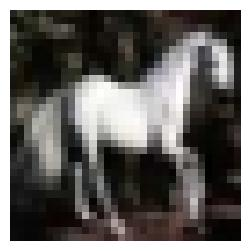

In [3]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

ds = load_dataset(
    provider="huggingface",
    dataset_name="cifar10",
    task="image-classification",
    split="test"
)
img = np.asarray(ds[13]['image'])

plt.figure(figsize=(3,3))
plt.axis('off')
_ = plt.imshow(img)

## Instantiate Protocol-Based Classifier <a name="instantiate-protocol-based-classifier"></a>

First, we need a classifier that uses the image classification protocol. Here we'll be using a configuration from Hugging Face. 

In [4]:
jatic_classifier = load_model(
    provider="huggingface",
    task="image-classification",
    model_name="aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"
)

/home/local/KHQ/emily.veenhuis/Documents/nrtk/venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Transform Protocol-Based Classifier <a name="transform-protocol-based-classifier"></a>

Now that we have our JATIC protocol-based classifier, we can wrap it so that it can be used directly with `xaitk-saliency`. We'll also define a preprocessor that converts our NumPy arrays to the PIL images that the model's default preprocessor expects. If we return PILs, the default preprocessor will still run. Alternatively, we could fully redefine the preprocessor, returning what the model directly expects as input, e.g. tensors.

In [5]:
def preprocessor(images: SupportsArray) -> SupportsArray:
    if isinstance(images, Sequence):
        preprocess_out = list()
        for img in images:
            preprocess_out.append(Image.fromarray(img))
        return preprocess_out
    else:
        return Image.fromarray(images)  # type: ignore #PIL is not considered ArrayLike currently

classifier = JATICImageClassifier(
    classifier=jatic_classifier, 
    preprocessor=preprocessor
)

## Use the Classifier as "Normal" <a name="use-classifier-as-normal"></a>

Now the classifier can be used just like it is a regular `ClassifyImage` implementation with `xaitk-saliency`.

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

We'll generate saliency maps for our selected example using the `SlidingWindowStack` implementation.

In [6]:
sal_generator = SlidingWindowStack(
    window_size=(2, 2), 
    stride=(1, 1), 
    threads=4
)
sal_generator.fill = (128, 128, 128)

In [7]:
print("Generating saliency maps...")
start = time.time()
sal_maps = sal_generator(
    img,
    classifier
)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating saliency maps...
Done in 95.64s


#### Display Saliency Maps <a name="display-saliency-maps"></a>

In [8]:
def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray, labels) -> None:    
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(24, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')
        
    for i, class_sal_map in enumerate(sal_maps):
        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.title(f"Pos Saliency:\n{labels[i]}")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.title(f"Neg Saliency:\n{labels[i]}")
        plt.axis('off')

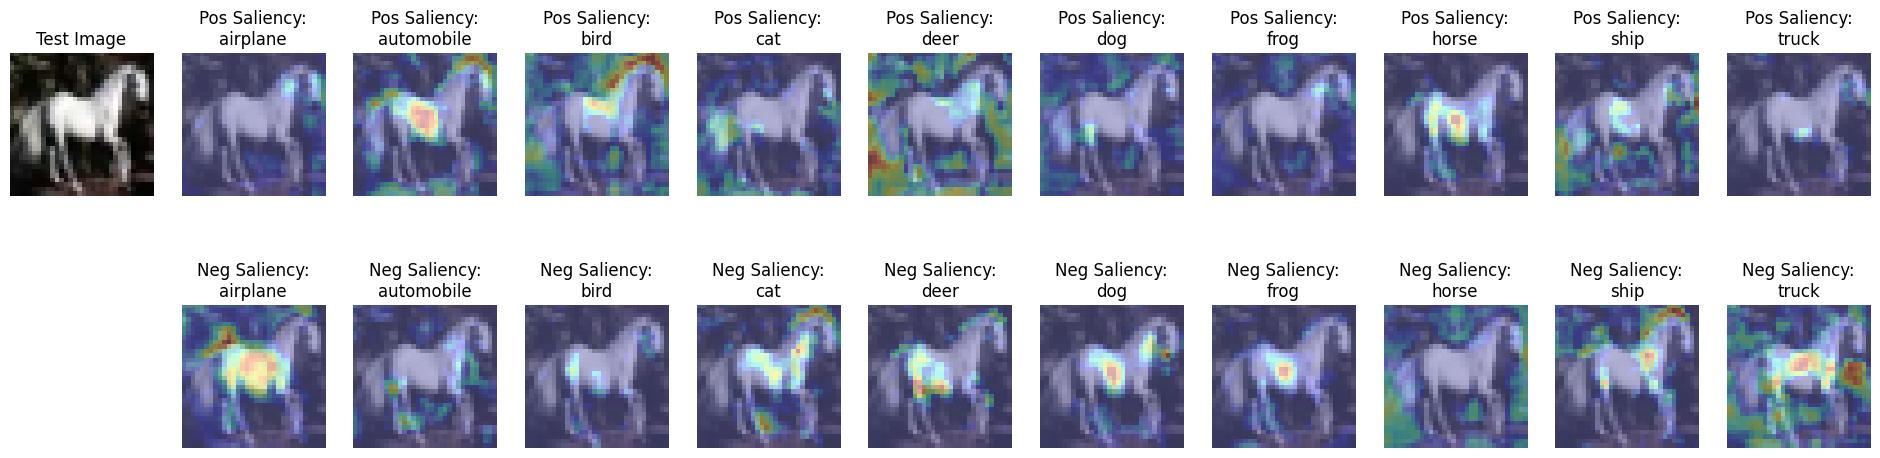

In [9]:
visualize_saliency(img, sal_maps, classifier.get_labels())